# 문자 단위 RNN으로 이름 분류하기
- 문자 하나(ex. a, b,....,z)를 하나의 one-hot벡터로 표현하여 예측 실시
- 한 문자의 벡터 길이는 alphabet의 길이(26)이다.
- 18개 언어로 된 수천 개의 성을 훈련시킨 후, 철자에 따라 이름이 어떤 언어인지 예측

#  DataLoad
- data/name 디렉토리에 18개 텍스트 파일이 포함되어 있다.
- 각 파일에는 한 줄에 하나의 이름이 포함되어 있다.(로마자)
- ASCII로 변환해야 한다.

In [ ]:
# data 보기
from io import open
import glob
import os

path = 'data/names/'
filenames = glob.glob(path + '*.txt')
print(filenames)
print('')
print(len(filenames))

In [ ]:
import unicodedata
import string # 모든 알파벳을 출력하기 위해 import

print(string.hexdigits) # 16진수 표현하는 문자들
print(string.punctuation) # 특수문자, 특수기호
print(string.whitespace) # 공백문자
print(string.printable) # 모든 문자 + 기호

all_letters = string.ascii_letters + ' .,;' # 알파벳(대 + 소) + 공백 + ,.;
all_letters

In [ ]:
# 유니코드 문자열을 일반 ASCII로 변환
# 한 단어를 문자 하나하나로 쪼개서 각각을 ascii로 변환
# 또한 변환된 단어의 분류가 'Mn'이 아니고 all_letters에 포함되어 있으면 출력
def Unicode_to_Ascii(s):
    word = ''.join(c for c in unicodedata.normalize('NFD', s)
           if unicodedata.category(c) != 'Mn' # Nonspacing Mark, 특정 언어에서 사용되는 기호
            and c in all_letters) # c가 all_letter에 포함되어 있는 것
    
    return word

print(Unicode_to_Ascii('Ślusàrski'))

In [ ]:
# 각 파일로부터 이름 불러오기
def readline(filename):
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    names = [name for name in lines]
    
    return names

lan_list = []
lan_name_list = {}

# 국가별 이름 목록사전 만들기{lan : [name1, name2...]}
for filename in filenames:
    lan = os.path.splitext(os.path.basename(filename))[0]
    lan_list.append(lan)
    name = readline(filename)
    lan_name_list[lan] = name
    
lan_n = len(lan_name_list)
print(lan_name_list_n)

### 변수 설명
- lan_list : 국가 목록
- lan_name_list : 국가별 이름 목록
- lan_name_list_n : 국가 개수

# 이름을 Tensor로 변환
- 하나의 문자(ex. a)를 표현하기 위해서는 size가 1xn_letter인 One-hot 벡터를 사용한다.
- a : Tensor[[1,0,0,0......,0]]
- b : Tensor[[0,1,0,0.......0]]
- z : Tensor[[0,0,0,0.......1]]
<br><br>
- 단어를 만들어 주기 위해 2차원 행렬(len_of_word x 1 x n_letters)

In [ ]:
import torch

# 한 letter의 index값을 출력
def Letter_to_Index(letter):
    letter_index = all_letters.find(letter) 
     
    return letter_index

# 각 letter별 index사전 만들기(one-hot 벡터)
def Letter_to_Tensor(letter):
    letter_tensor = torch.zeros(1, len(all_letters))
    letter_tensor[0][Letter_to_Index(letter)] = 1
    
    return letter_tensor

def Name_to_Tensor(name):
    tensor = torch.zeros(len(name), 1, len(all_letters))
    for i, c in enumerate(name):
        tensor[i][0][Letter_to_Index(c)] = 1
        
    return tensor

print(Letter_to_Tensor('j'))
print(Name_to_Tensor('justin').size())

# RNN 생성
- input layer와 hidden layer가 합쳐져 output layer(i2o)를 형성
- input layer와 hideen layer가 합쳐져 다음 hidden layer(i2h)를 형성
- i2o인 경우 sofrmax 함수를 이용해 확률값 출력하고 정답label과 오차값 계산
- i2h인 경우 두 번째 h2로 
넘어간다.

# 진행 과정
1. 이름 하나를 구성하는 각각의 letter들이 한 글자씩 input으로 들어간다.
2. 

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1) # 열로 붙이기
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden

    def initHidden(self):
        
        return torch.zeros(1, self.hidden_size)
    
hidden_n = 128
letter_n = len(all_letters)
lan_n = len(lan_name_list)


rnn = RNN(letter_n, hidden_n, lan_n)

In [ ]:
with torch.no_grad():
    input = Letter_to_Tensor('a')
    hidden = torch.zeros(1, hidden_n)

    output, hidden = rnn(input, hidden)
    print(output) # 출력은 국가 중 하나이고, 값이 높을수록 가능성이 높다.

In [ ]:
with torch.no_grad():
    input = Name_to_Tensor('justin')
    hidden = torch.zeros(1, hidden_n)
    output, hidden = rnn(input[0], hidden)
    
    print(output) # 출력은 국가 중 하나이고, 값이 높을수록 가능성이 높다.

# 학습하기 전 준비과정
도움되는 함수 몇 가지가 필요하다.
 1. output 결과로부터 가장 큰 값이 무엇인지 출력하기(가장 가능성이 큰 국가 출력)
 2. 학습 예시를 출력해주는 함수

In [ ]:
def LanfromOutput(output):
    top_val, top_i = output.topk(1) # Tensor내에 최대값의 value와 index 찾기(input값으로 개수 선택)
    lan_i = top_i[0].item()
    
    return lan_list[lan_i], lan_i

LanfromOutput(output)

In [ ]:
# 학습 예시(이름과 언어) 얻는 빠른 방법도 필요하다.
import random

def RandomChoice(l):
    lan_random = l[random.randint(0, len(l) - 1)]
    
    return lan_random

def RandomTrainingExample():
    lan_random = RandomChoice(lan_list) # 랜덤 국가 선택
    name = RandomChoice(lan_name_list[lan_random]) # 선택된 국가 중 랜덤 이름 선택
    lan_tensor = torch.tensor([lan_list.index(lan_random)], dtype = torch.long) # 국가 index의 tensor
    name_tensor = Name_to_Tensor(name) # 이름을 tensor로
    
    return lan_random, name, lan_tensor, name_tensor

for i in range(10):
    lan, name, lan_tensor, name_tensor = RandomTrainingExample()
    print('Langauge : %s / name = %s' %(lan, name))

# 학습 과정
1. input과 target의 Tensor 생성
2. 0으로 초기화 된 hidden layer 생성
3. 각 문자 읽기 - 다음 문자를 위한 은닉 상태 유지
4. output과 target 비교하여 오차 계산
5. 오차 역전파
6. output과 loss 출력

In [ ]:
# 일단 optimizer를 사용 안하고 그냥 했는데... 일단 그냥 해봄
import torch.optim as optim
optimizer = optim.SGD(rnn.parameters(), lr = 0.005)  

loss_function = nn.NLLLoss()
learning_rate = 0.005

def train(lan_tensor, name_tensor):
    
    hidden = rnn.initHidden()
    
    optimizer.zero_grad()
    
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
        
    loss = loss_function(output, lan_tensor)
    loss.backward()
    
    optimizer.step()
    #for p in rnn.parameters():
    #    p.data.add_(-learning_rate, p.grad.data)
  
    return output, loss.item()

In [ ]:
import time
import math

iter_n = 100000

loss_avg = 0
loss_list = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


for i in range(1, iter_n + 1):
    lan, name, lan_tensor, name_tensor = RandomTrainingExample()
    output, loss = train(lan_tensor, name_tensor)
    loss_avg += loss
    
    if i % 5000 == 0:
        guess, guess_i = LanfromOutput(output)
        correct = '✓' if guess == lan else  '✗ (%s)' % lan
        print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / iter_n * 100, timeSince(start), loss, name, guess, correct))

    if i % 1000 == 0:
        loss_list.append(loss_avg / 1000)
        loss_avg = 0        

# Loss값 시각화

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(loss_list)

# 나만의 방식으로 재도전
- 문서에 나와있는 방식은 너무 복잡하다.
- 좀 더 간단하게 구현 시도!
- 사실 대부분 비슷한데.... 디테일이 다르다

# 데이터 불러오기

In [213]:
import glob
from io import open

path = 'data/names/'
filenames = glob.glob(path + '*.txt')
print(filenames)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Vietnamese.txt']


# 국가별 이름 사전 만들기
- {국가1 : [이름1, 이름2...], 국가2 : [이름1, 이름2...]}

In [231]:
import os
from io import open

lan_name_dict = {}
lan_list = []

for filename in filenames:
    names = open(filename, encoding = 'utf-8').read().strip().split('\n')
    lan = os.path.splitext(os.path.basename(filename))[0]
    lan_list.append(lan)
    lan_name_dict[lan] = names
    
lan_list_n = len(lan_list)
lan_name_dict_n = len(lan_name_dict)

In [232]:
names_n = []
for lan in lan_list:
    name_n = len(lan_name_dict[lan])
    names_n.append(name_n)

print('Number of languge : %d' %lan_list_n)
print('Number of names : %d' %sum(names_n))

Number of languge : 18
Number of names : 20074


# 이름을 Unicode -> Ascii로 변환

In [233]:
import unicodedata
import string

letters = string.ascii_letters + " .,;'"
letters_n = len(letters)

def Unicode_to_Ascii(s):
    w = ''.join(c for c in unicodedata.normalize('NFD', s)
               if unicodedata.category(c) != 'Mn'
               and c in letters)
    
    return w

for lan, names in lan_name_dict.items():
    converted_names = [Unicode_to_Ascii(name) for name in names]
    lan_name_dict[lan] = converted_names  

In [234]:
lan_name_dict['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

# 이름을 Tensor로 변환
## 방법은 2가지
1. Lookup 방식을 이용하기 위해 letter_to_vector 사전을 만든다.
2. 함수를 이용해서 해당 letter에 해당하는 vector를 바로 만든다.

In [235]:
# 1. lookup 방식
import torch

letter_to_vec = {}

for i, l in enumerate(letters):
    vec = torch.zeros(1, letters_n)
    vec[0][i] = 1
    letter_to_vec[l] = vec
    
def Name_to_Vec(name):
    vec = torch.zeros(len(name), 1, letters_n)
    for i, l in enumerate(name):
        vec[i][0] = letter_to_vec[l]
        
    return vec

In [236]:
print(letter_to_vec['J'])
print(Name_to_Vec('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# RNN 모델
- input과 hidden을 합치는 combined layer
- input에서 output으로 가는 i2o layer
- input에서 hidden으로 가는 i2h layer
- softmax를 적용시키는 softmax layer

In [258]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.softmax = nn.LogSoftmax(dim = 1)
        
    def forward(self, input, hidden):
        
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        
        return output, hidden
    
    def initHidden(self):
        
        return torch.zeros(1, self.hidden_size)
    
hidden_n = 128
rnn = RNN(letters_n, hidden_n, lan_list_n)

In [238]:
# letter 1개 예시
with torch.no_grad():
    input_example = letter_to_vec['a']
    hidden_example = torch.zeros(1, hidden_n)
    output, next_hidden = rnn(input_example, hidden_example)
    
    print(output)

tensor([[-2.9363, -2.9287, -2.9011, -2.9305, -2.8904, -2.8532, -2.8082, -2.9476,
         -2.8826, -2.8834, -2.8909, -2.8265, -2.8313, -2.9523, -2.8937, -2.8793,
         -2.8974, -2.9076]])


In [239]:
# Name 1개 예시
with torch.no_grad():
    input_example = Name_to_Vec('Justin')
    hidden_example = torch.zeros(1, hidden_n)
    output, next_hidden = rnn(input_example[0], hidden_example)
    print(output)

tensor([[-2.9070, -2.9254, -2.9155, -2.8734, -2.9776, -2.8116, -2.8526, -2.9213,
         -2.9353, -2.8281, -2.8709, -2.9220, -2.8405, -2.9663, -2.9308, -2.9393,
         -2.8427, -2.7917]])


# input 데이터 랜덤으로 생성
- Train할 이름들 랜덤으로 생성시키기
 1. 랜덤으로 국가 선택
 2. 해당 국가에서 랜덤으로 이름 선택
- Output = 국가, 이름, 국가Tensor, 이름Tensor

In [240]:
import random

def RandomPick():
    lan_random_index = random.randint(0, lan_list_n - 1)
    lan_random = lan_list[lan_random_index]
    name_random_index = random.randint(0, len(lan_name_dict[lan_random]) - 1)
    name_random = lan_name_dict[lan_random][name_random_index]
    lan_tensor = torch.tensor([lan_list.index(lan_random)], dtype = torch.long)
    name_tensor = Name_to_Vec(name_random)
    
    return lan_random, name_random, lan_tensor, name_tensor

In [241]:
for i in range(10):
    lan, name, lan_tensor, name_tensor = RandomPick()
    print('Language : %s / Name : %s' %(lan, name))

Language : Japanese / Name : Higashikuni
Language : Portuguese / Name : Serafim
Language : Irish / Name : Mcguire
Language : Italian / Name : Corna
Language : Arabic / Name : Bishara
Language : French / Name : Severin
Language : English / Name : Awad
Language : Chinese / Name : Gauk
Language : Irish / Name : Cnaimhin
Language : Dutch / Name : Klerx


# 학습하기

In [261]:
import torch.optim as optim

loss_function = nn.NLLLoss()
optimizer = optim.SGD(rnn.parameters(), lr = 0.01)

iter_n = 10000
loss_current = 0
loss_list = []

for i in range(1, iter_n):
    
    lan, name, lan_tensor, name_tensor = RandomPick()
    input = name_tensor
    target = lan_tensor
    hidden = rnn.initHidden()
    
    optimizer.zero_grad()
    
    for j in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[j], hidden)
        
    loss = loss_function(output, lan_tensor)
    loss.backward()
    optimizer.step()
    
    loss_current += loss
    
    if i % 500 == 0:
        print(loss_current/ 50)
        
    if i % 50 == 0:
        loss_current = loss_current / 50
        loss_list.append(loss_current)
        loss_current = 0

tensor(2.5945, grad_fn=<DivBackward0>)
tensor(2.6129, grad_fn=<DivBackward0>)
tensor(2.5781, grad_fn=<DivBackward0>)
tensor(2.3814, grad_fn=<DivBackward0>)
tensor(2.3599, grad_fn=<DivBackward0>)
tensor(2.3470, grad_fn=<DivBackward0>)
tensor(2.2583, grad_fn=<DivBackward0>)
tensor(2.2956, grad_fn=<DivBackward0>)
tensor(2.2900, grad_fn=<DivBackward0>)
tensor(2.1942, grad_fn=<DivBackward0>)
tensor(2.0031, grad_fn=<DivBackward0>)
tensor(1.9325, grad_fn=<DivBackward0>)
tensor(2.1109, grad_fn=<DivBackward0>)
tensor(1.9813, grad_fn=<DivBackward0>)
tensor(2.0251, grad_fn=<DivBackward0>)
tensor(1.8409, grad_fn=<DivBackward0>)
tensor(2.0684, grad_fn=<DivBackward0>)
tensor(1.6962, grad_fn=<DivBackward0>)
tensor(1.6663, grad_fn=<DivBackward0>)


# Loss 시각화

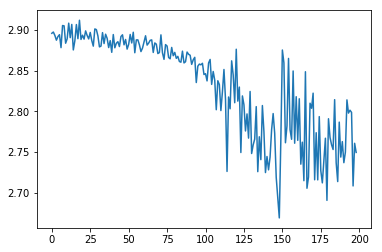

In [260]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(loss_list)

# 새로 배운 사실

1. unicodedata.normalize('NFD' or 'NFC', word) 역할
 - NFD(Normalization From Decomposition) : 소리 마디를 분해
 - NFC(Normalization From Composition) : 소리 마디를 결합
 - 즉 일단 A말고 위에 A'처럼 소리마디가 포함 된 언어의 경우 두 부분을 분해하거나 결합하는 인코딩